# Environmental Sound Classification


## Step 1. Importing Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import librosa.display
from tqdm import tqdm
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras.models as models
import tensorflow.keras.layers as layers

%matplotlib inline
%load_ext tensorboard

2023-10-08 16:00:13.296328: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-08 16:00:14.129924: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Step 2. Loading and Preprocessing

In [3]:
CSV_FILE_PATH = "./ESC-50-master/meta/esc50.csv"
DATA_PATH = "./ESC-50-master/audio/"

In [4]:
#reading the csv file
df = pd.read_csv(CSV_FILE_PATH)
df

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A
...,...,...,...,...,...,...,...
1995,5-263831-B-6.wav,5,6,hen,False,263831,B
1996,5-263902-A-36.wav,5,36,vacuum_cleaner,False,263902,A
1997,5-51149-A-25.wav,5,25,footsteps,False,51149,A
1998,5-61635-A-8.wav,5,8,sheep,False,61635,A


In [5]:
df_10 = df 
df_10 = df_10.drop(['fold','esc10','src_file','take'], axis=1)
df_10

,filename,target,category
0,1-100032-A-0.wav,0,dog
1,1-100038-A-14.wav,14,chirping_birds
2,1-100210-A-36.wav,36,vacuum_cleaner
3,1-100210-B-36.wav,36,vacuum_cleaner
4,1-101296-A-19.wav,19,thunderstorm
...,...,...,...
1995,5-263831-B-6.wav,6,hen
1996,5-263902-A-36.wav,36,vacuum_cleaner
1997,5-51149-A-25.wav,25,footsteps
1998,5-61635-A-8.wav,8,sheep


In [6]:
classes = df_10['category'].unique()
classes

array(['dog', 'chirping_birds', 'vacuum_cleaner', 'thunderstorm',
       'door_wood_knock', 'can_opening', 'crow', 'clapping', 'fireworks',
       'chainsaw', 'airplane', 'mouse_click', 'pouring_water', 'train',
       'sheep', 'water_drops', 'church_bells', 'clock_alarm',
       'keyboard_typing', 'wind', 'footsteps', 'frog', 'cow',
       'brushing_teeth', 'car_horn', 'crackling_fire', 'helicopter',
       'drinking_sipping', 'rain', 'insects', 'laughing', 'hen', 'engine',
       'breathing', 'crying_baby', 'hand_saw', 'coughing',
       'glass_breaking', 'snoring', 'toilet_flush', 'pig',
       'washing_machine', 'clock_tick', 'sneezing', 'rooster',
       'sea_waves', 'siren', 'cat', 'door_wood_creaks', 'crickets'],
      dtype=object)

In [7]:
class_dict = {i:x for x,i in enumerate(classes)}
class_dict

{'dog': 0,
 'chirping_birds': 1,
 'vacuum_cleaner': 2,
 'thunderstorm': 3,
 'door_wood_knock': 4,
 'can_opening': 5,
 'crow': 6,
 'clapping': 7,
 'fireworks': 8,
 'chainsaw': 9,
 'airplane': 10,
 'mouse_click': 11,
 'pouring_water': 12,
 'train': 13,
 'sheep': 14,
 'water_drops': 15,
 'church_bells': 16,
 'clock_alarm': 17,
 'keyboard_typing': 18,
 'wind': 19,
 'footsteps': 20,
 'frog': 21,
 'cow': 22,
 'brushing_teeth': 23,
 'car_horn': 24,
 'crackling_fire': 25,
 'helicopter': 26,
 'drinking_sipping': 27,
 'rain': 28,
 'insects': 29,
 'laughing': 30,
 'hen': 31,
 'engine': 32,
 'breathing': 33,
 'crying_baby': 34,
 'hand_saw': 35,
 'coughing': 36,
 'glass_breaking': 37,
 'snoring': 38,
 'toilet_flush': 39,
 'pig': 40,
 'washing_machine': 41,
 'clock_tick': 42,
 'sneezing': 43,
 'rooster': 44,
 'sea_waves': 45,
 'siren': 46,
 'cat': 47,
 'door_wood_creaks': 48,
 'crickets': 49}

In [8]:
df_10['target'] = df_10['category'].map(class_dict)
df_10

,filename,target,category
0,1-100032-A-0.wav,0,dog
1,1-100038-A-14.wav,1,chirping_birds
2,1-100210-A-36.wav,2,vacuum_cleaner
3,1-100210-B-36.wav,2,vacuum_cleaner
4,1-101296-A-19.wav,3,thunderstorm
...,...,...,...
1995,5-263831-B-6.wav,31,hen
1996,5-263902-A-36.wav,2,vacuum_cleaner
1997,5-51149-A-25.wav,20,footsteps
1998,5-61635-A-8.wav,14,sheep


## Step 3. Visualization

* if you have little or no idea about mel-spectrogram and MFCC visit this site.
[Introduction to feature extraction](https://towardsdatascience.com/how-to-apply-machine-learning-and-deep-learning-methods-to-audio-analysis-615e286fcbbc)

[](http://)

Taking one sample from each of the 10 classes for visualization

In [9]:
sample_df = df_10.drop_duplicates(subset=['target'])
sample_df

,filename,target,category
0,1-100032-A-0.wav,0,dog
1,1-100038-A-14.wav,1,chirping_birds
2,1-100210-A-36.wav,2,vacuum_cleaner
4,1-101296-A-19.wav,3,thunderstorm
6,1-101336-A-30.wav,4,door_wood_knock
7,1-101404-A-34.wav,5,can_opening
8,1-103298-A-9.wav,6,crow
11,1-104089-A-22.wav,7,clapping
17,1-115545-A-48.wav,8,fireworks
24,1-116765-A-41.wav,9,chainsaw


In [10]:
signals = {}
mel_spectrograms = {}
mfccs = {}

for row in tqdm(sample_df.iterrows()):  
    signal , rate = librosa.load(DATA_PATH+ row[1][0])
    signals[row[1][2]] = signal    
    
    mel_spec = librosa.feature.melspectrogram(y=signal , sr=rate ,  n_fft=2048, hop_length=512)
    mel_spec = librosa.power_to_db(mel_spec, ref=np.max) 
    mel_spectrograms[row[1][2]] = mel_spec
    
    mfcc = librosa.feature.mfcc(y=signal , sr=rate , n_mfcc=13, dct_type=3)
    mfccs[row[1][2]] = mfcc

50it [00:03, 13.83it/s]


In [11]:
def plot_signal(signal):
    """
    this function will take the signal dictionary and plot the signals
    """
    fig , axes = plt.subplots(nrows=5 , ncols=2 , sharex =False ,sharey=True,
                             figsize=(40,20))
    fig.suptitle('Time series',size=15)
    i=0
    for x in range(5):
        for y in range(2):
            axes[x,y].set_title(list(signal.keys())[i])
            axes[x,y].plot(list(signal.values())[i])
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i +=1

In [12]:
def dis_feature(mfccs, cmap=None):
    """
    this function will take the mfcc/mel_spectrogram dictionary and plot the signals
    """
    fig ,axes= plt.subplots(nrows=5 , ncols=2 , sharex=False, sharey=True , figsize=(40,20))
    fig.suptitle('mel')
    i=0
    for x in range(5):
        for y in range(2):
            axes[x,y].set_title(list(mfccs.keys())[i])
            axes[x,y].imshow(list(mfccs.values())[i], cmap=cmap,interpolation='nearest')
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i+=1

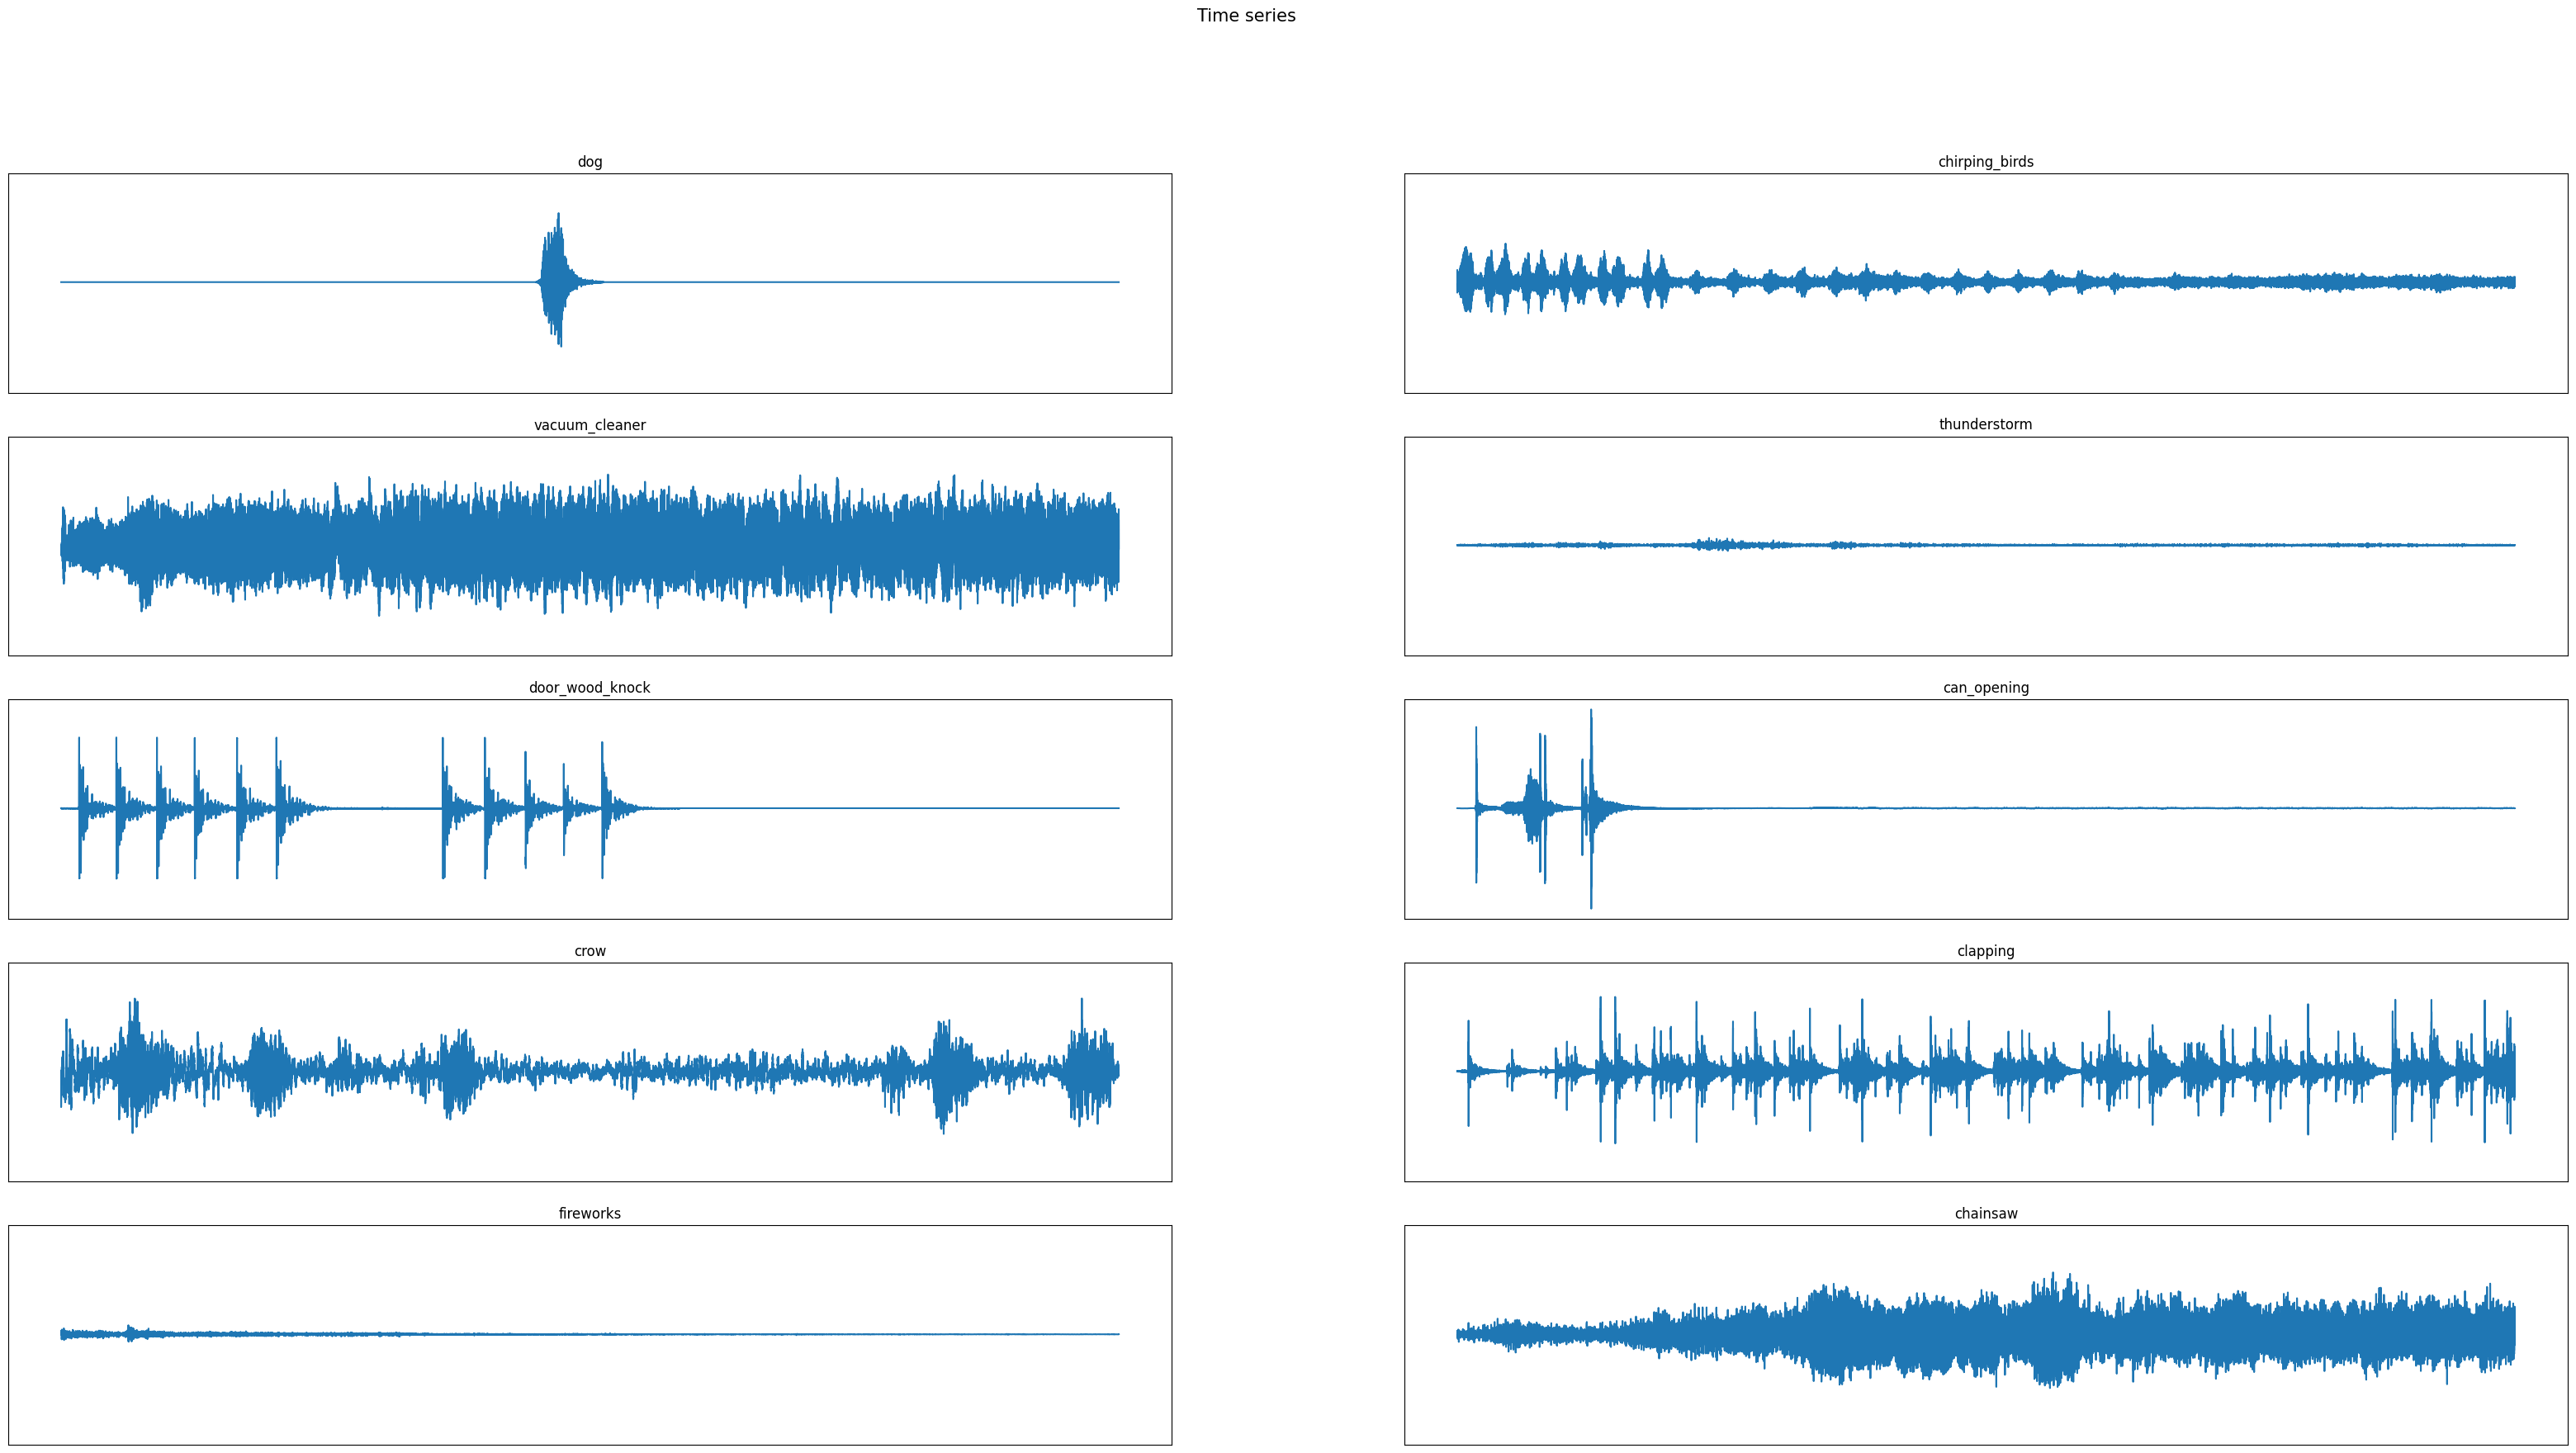

In [13]:
plot_signal(signals)

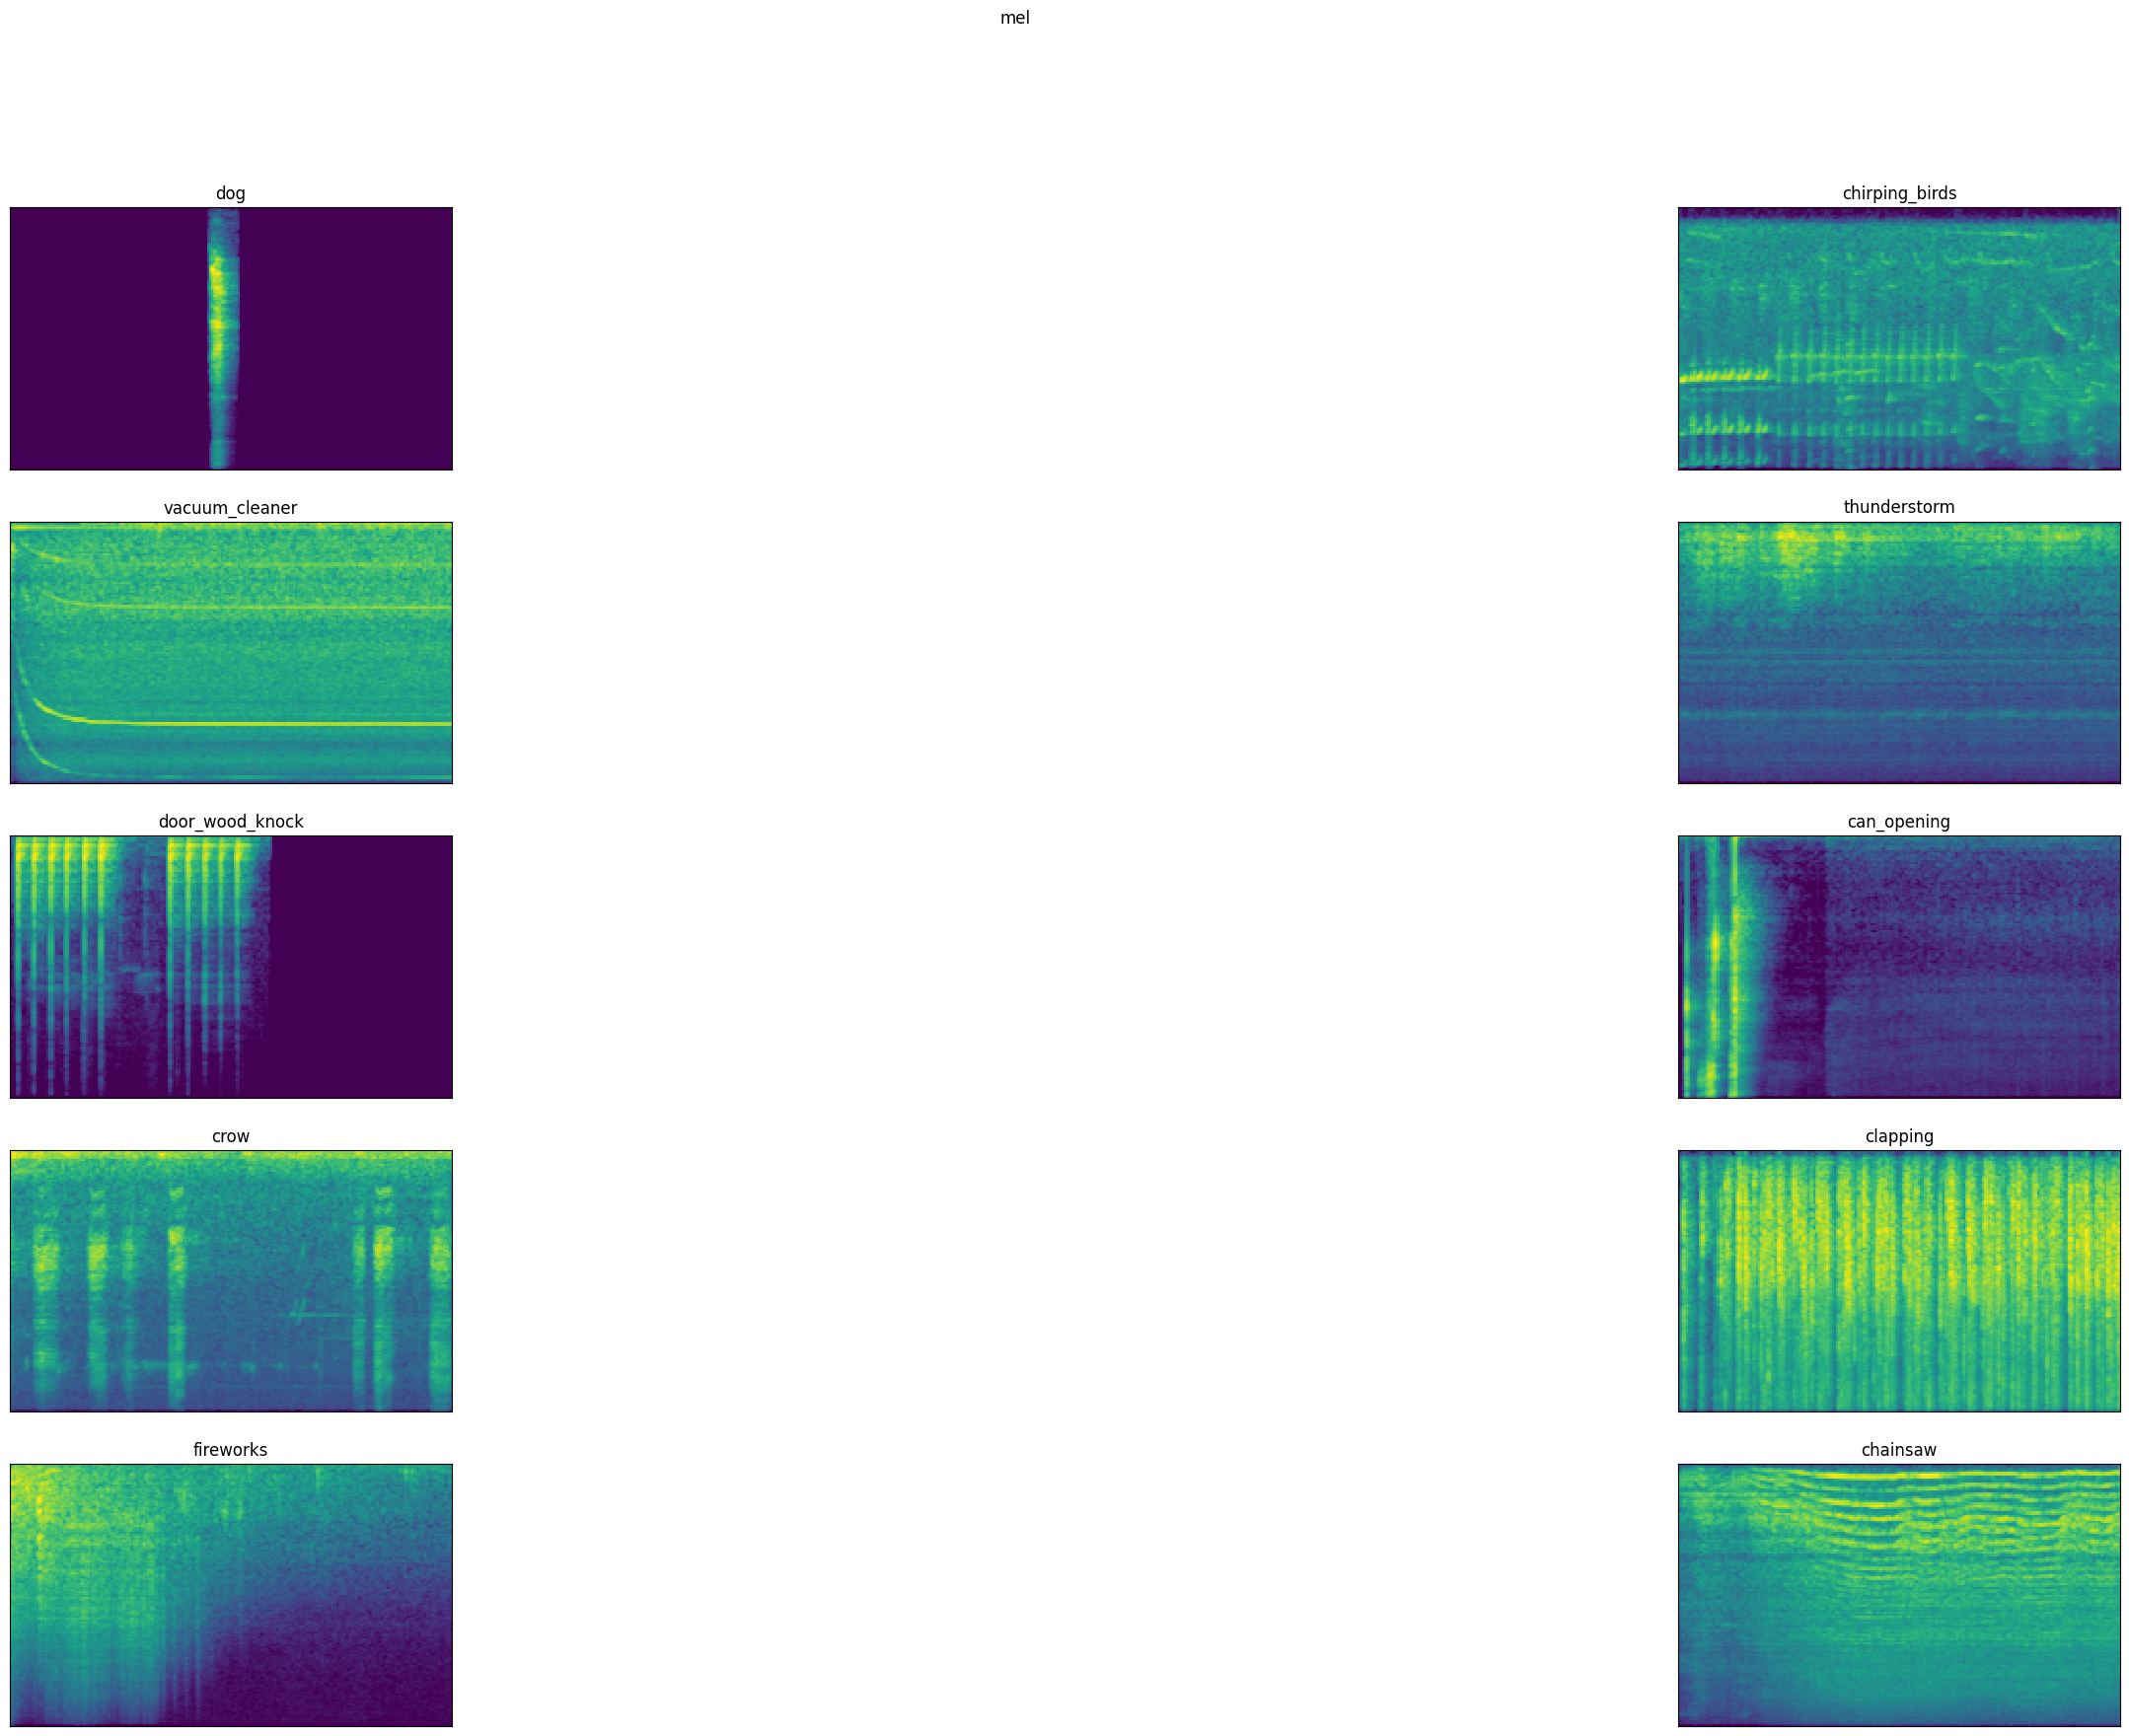

In [14]:
dis_feature(mel_spectrograms)

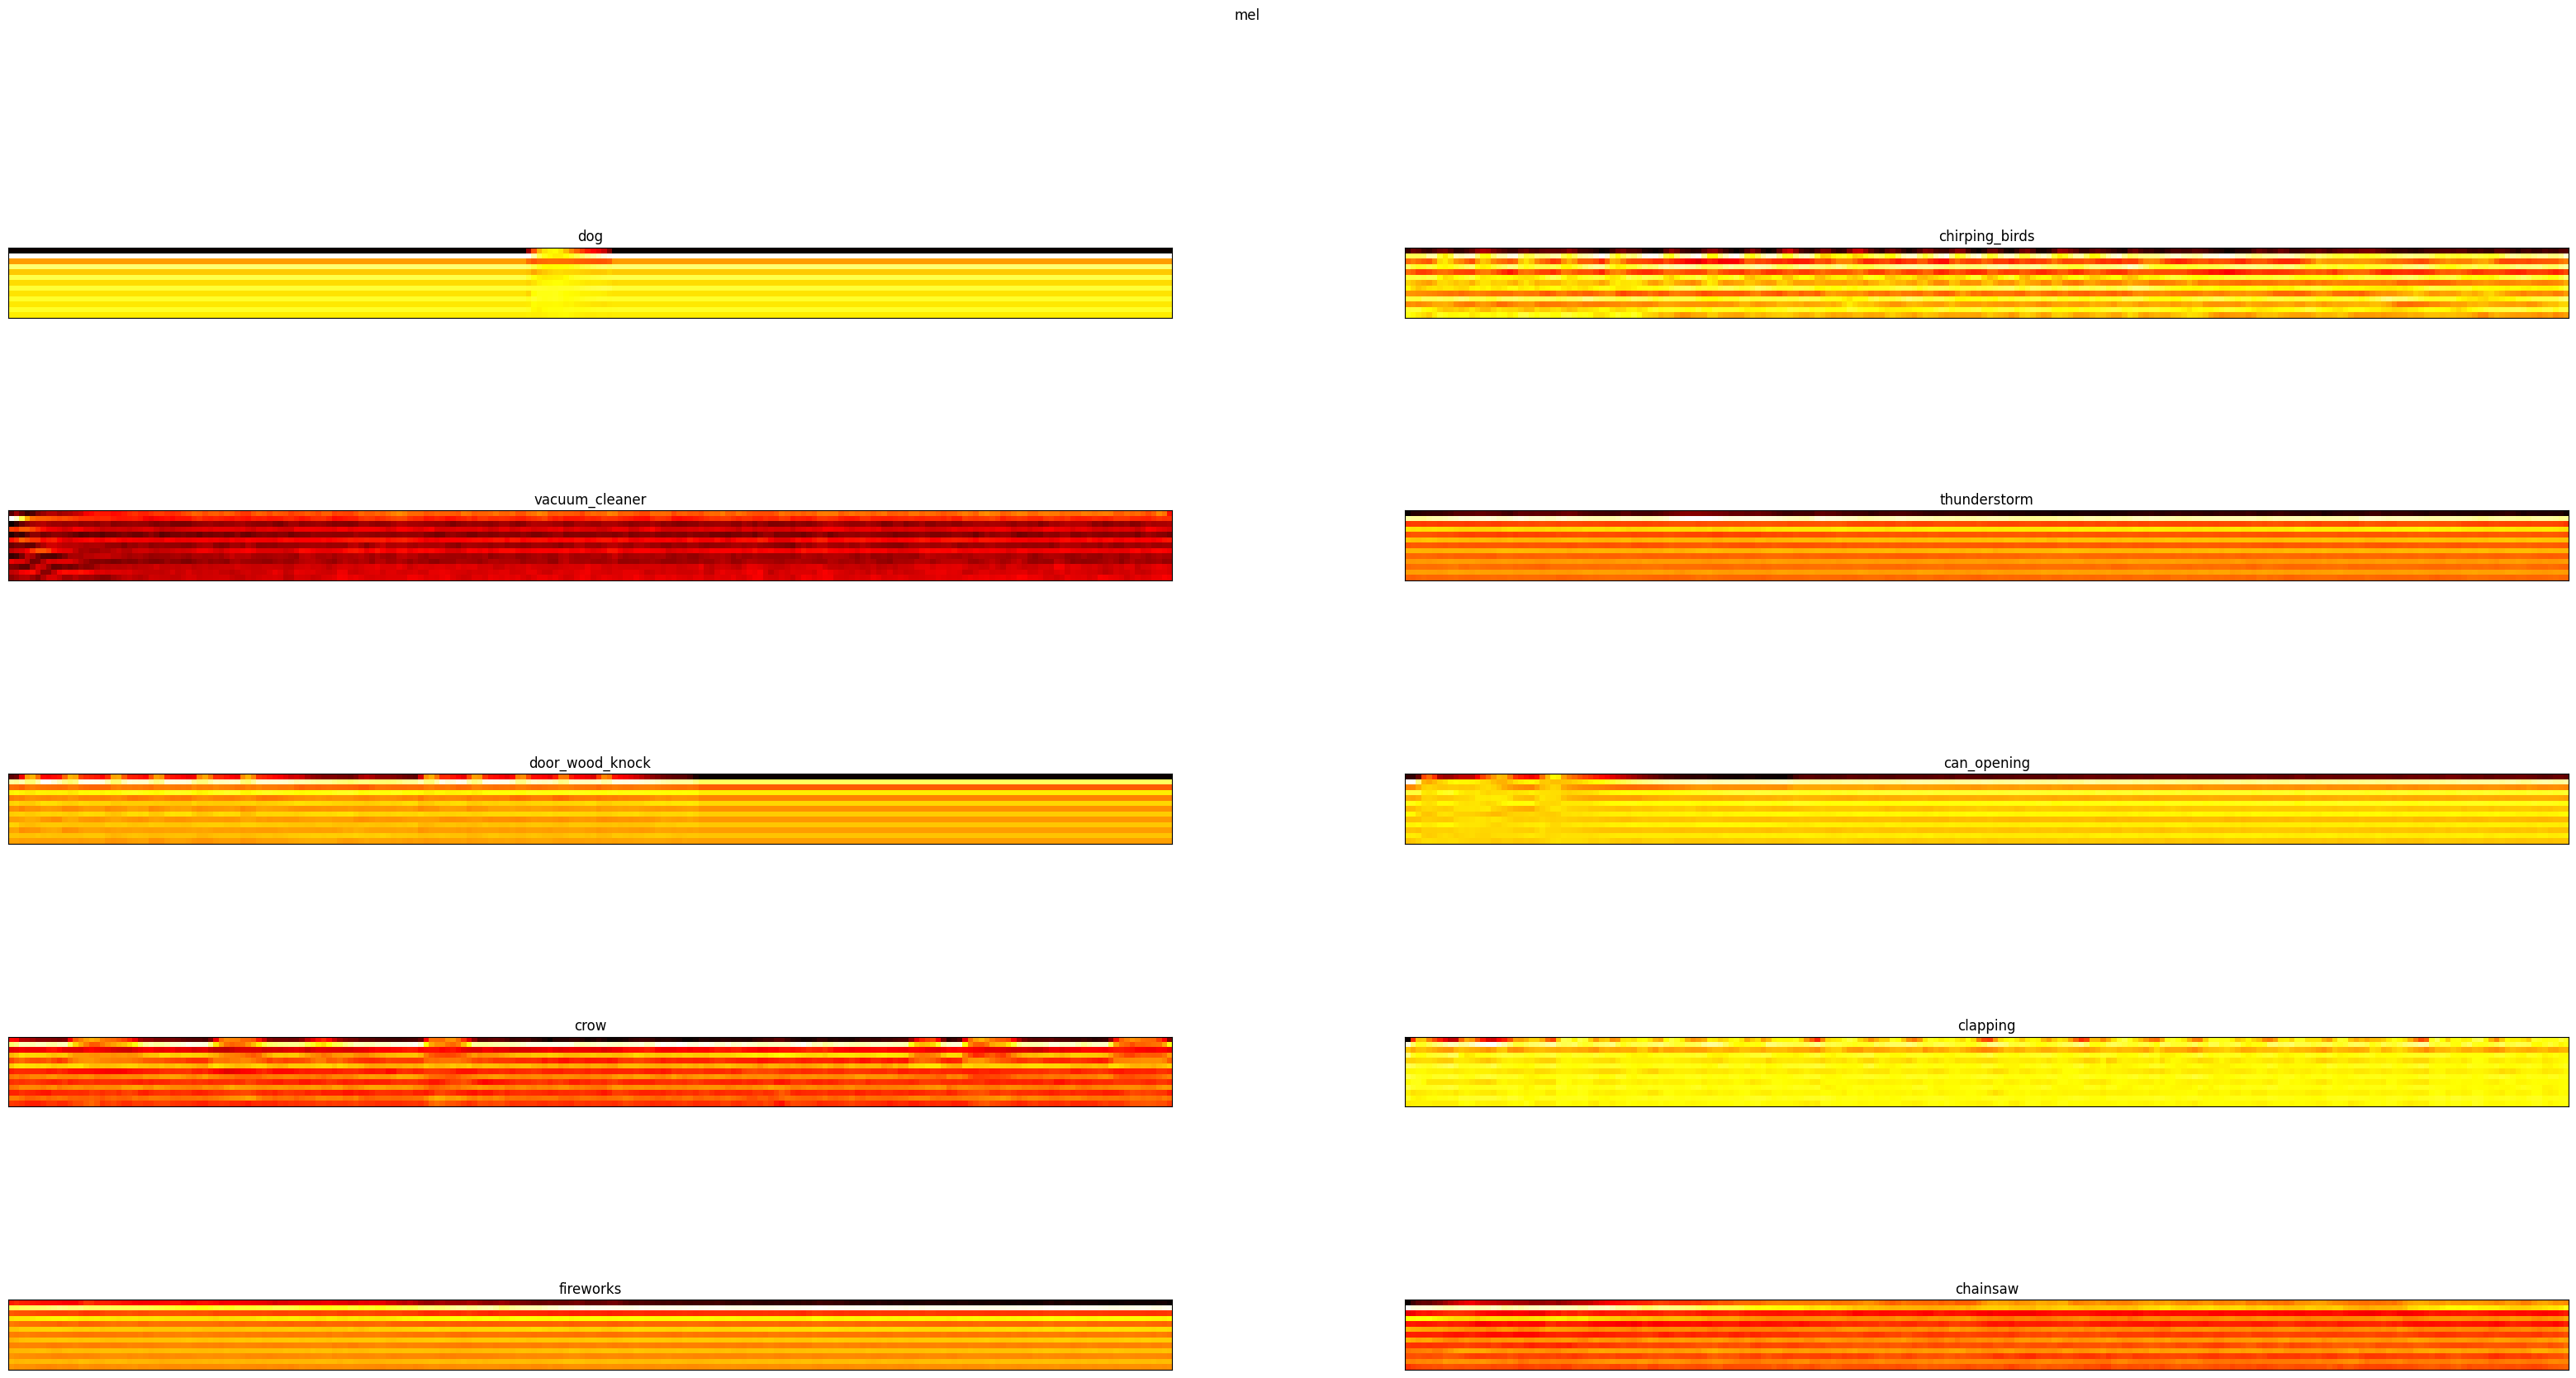

In [15]:
dis_feature(mfccs, cmap='hot')

## Step 4. Getting Data ready for training

* Now we are going to take a three random 2 second clip from each audio file. this will increase the data size and also classification speed increases.
* the following code iterate through every file and take three random clip from it.

In [16]:
X , y = [] , []
for data in tqdm(df_10.iterrows()):
  sig , sr = librosa.load(DATA_PATH+data[1][0])
  for i in range(3):
    n = np.random.randint(0, len(sig)-(sr*2))
    sig_ = sig[n : int(n+(sr*2))]
    mfcc_ = librosa.feature.mfcc(y=sig_ , sr=sr, n_mfcc=13)
    X.append(mfcc_)
    y.append(data[1][1])

# convert list to numpy array
X = np.array(X) 
y = np.array(y)

2000it [01:22, 24.32it/s]


In [17]:
X.shape
y.shape

(6000, 13, 87)

(6000,)

In [18]:
#one-hot encoding the target
y = tf.keras.utils.to_categorical(y , num_classes=50)
X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)

In [19]:
X.shape
y.shape

(6000, 13, 87, 1)

(6000, 50)

In [20]:
x_train , x_val , y_train , y_val = train_test_split(X , y ,test_size=0.2, random_state=2020)

## Step 5. Model

In [21]:
INPUTSHAPE = (13,87,1)

In [22]:
model =  models.Sequential([
                          layers.Conv2D(16*5 , (3,3),activation = 'relu',padding='valid', input_shape = INPUTSHAPE),
                          layers.Conv2D(16*5, (3,3), activation='relu',padding='valid'),

                          layers.Conv2D(32*5, (3,3), activation='relu',padding='valid'),
                          layers.Conv2D(32*5, (3,3), activation='relu',padding='valid'),

                          layers.Conv2D(64*5, (3,3), activation='relu',padding='valid'),
                          layers.Conv2D(32*5, (3,3), activation='relu',padding='valid'),
                          layers.GlobalAveragePooling2D(),
    
                          layers.Dense(32*5 , activation = 'relu'),
                          layers.Dense(10*5 , activation = 'softmax')    
])

model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = 'acc')

2023-10-08 16:02:11.376002: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 11, 85, 80)        800       
                                                                 
 conv2d_1 (Conv2D)           (None, 9, 83, 80)         57680     
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 81, 160)        115360    
                                                                 
 conv2d_3 (Conv2D)           (None, 5, 79, 160)        230560    
                                                                 
 conv2d_4 (Conv2D)           (None, 3, 77, 320)        461120    
                                                                 
 conv2d_5 (Conv2D)           (None, 1, 75, 160)        460960    
                                                                 
 global_average_pooling2d (  (None, 160)               0

In [24]:
%mkdir "cpkt"
%mkdir "logs"

mkdir: cannot create directory ‘cpkt’: File exists
mkdir: cannot create directory ‘logs’: File exists


In [25]:
LOGDIR = "logs"
CPKT = "cpkt/"

In [26]:
from tensorflow import keras
import os

#this callback is used to prevent overfitting.
callback_1 = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto',
    baseline=None, restore_best_weights=False
)

# Define the path where you want to save the best model
best_model_dir = "BestModelTF"
os.makedirs(best_model_dir, exist_ok=True)
best_model_path = os.path.join(best_model_dir, "best_model2.h5")

# Define a ModelCheckpoint callback to save the best model
checkpoint = keras.callbacks.ModelCheckpoint(
    best_model_path,
    monitor='val_acc', 
    verbose=1,
    save_best_only=True,  
    mode='max', 
    save_weights_only=False, 
    save_format='h5',  
)

# Callback to save training logs to a CSV file with additional metrics
class CustomCSVLogger(keras.callbacks.CSVLogger):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = self.model.optimizer.lr.numpy()  
        logs['train_acc'] = logs.pop('acc')  
        logs['train_loss'] = logs.pop('loss')  
        logs['val_acc'] = logs.pop('val_acc') 
        logs['val_loss'] = logs.pop('val_loss') 
        super().on_epoch_end(epoch, logs)

# Define a custom CSV logger that includes learning rate and renames metrics
csv_logger = CustomCSVLogger('BestModelTF/training_log.csv', separator=',', append=True)


In [27]:
history = model.fit(x_train,y_train ,
            validation_data=(x_val,y_val),
            epochs=200,
            callbacks = [checkpoint, csv_logger])

Epoch 1/200
150/150 [==============================] - ETA: 0s - loss: 3.4056 - acc: 0.1133
Epoch 1: val_acc improved from -inf to 0.20333, saving model to BestModelTF/best_model.h5
150/150 [==============================] - 45s 288ms/step - loss: 3.4056 - acc: 0.1133 - lr: 0.0010 - train_acc: 0.1133 - train_loss: 3.4056 - val_acc: 0.2033 - val_loss: 2.9275
Epoch 2/200


/home/alsafarpour/milad/4ESC50-CNN1/venv/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


150/150 [==============================] - ETA: 0s - loss: 2.7961 - acc: 0.2279
Epoch 2: val_acc improved from 0.20333 to 0.27500, saving model to BestModelTF/best_model.h5
150/150 [==============================] - 37s 248ms/step - loss: 2.7961 - acc: 0.2279 - lr: 0.0010 - train_acc: 0.2279 - train_loss: 2.7961 - val_acc: 0.2750 - val_loss: 2.5723
Epoch 3/200
150/150 [==============================] - ETA: 0s - loss: 2.3715 - acc: 0.3260
Epoch 3: val_acc improved from 0.27500 to 0.38333, saving model to BestModelTF/best_model.h5
150/150 [==============================] - 27s 183ms/step - loss: 2.3715 - acc: 0.3260 - lr: 0.0010 - train_acc: 0.3260 - train_loss: 2.3715 - val_acc: 0.3833 - val_loss: 2.2187
Epoch 4/200
150/150 [==============================] - ETA: 0s - loss: 2.0197 - acc: 0.4306
Epoch 4: val_acc improved from 0.38333 to 0.45750, saving model to BestModelTF/best_model.h5
150/150 [==============================] - 27s 178ms/step - loss: 2.0197 - acc: 0.4306 - lr: 0.0010 -

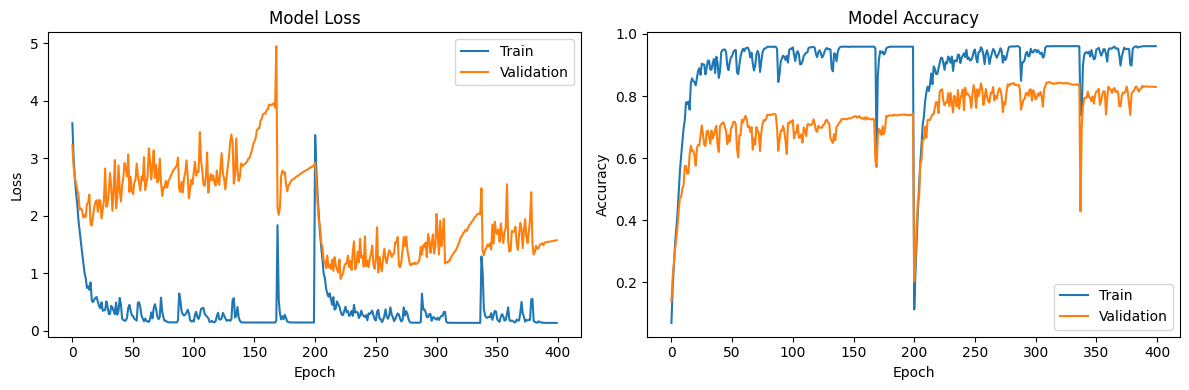

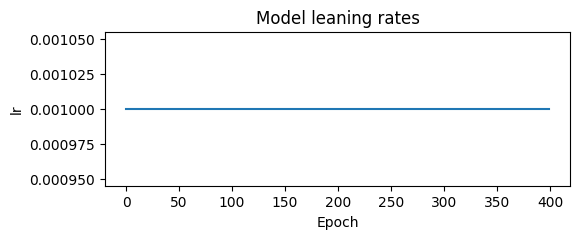

In [28]:
# Load the CSV file into a pandas DataFrame
df = pd.read_csv('BestModelTF/training_log.csv') 

validation_loss = df['val_loss']
validation_accuracy = df['val_acc']
train_loss = df['train_loss']
train_accuracy = df['train_acc']
lr_logs = df['lr']

# Plot training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train')
plt.plot(validation_loss, label='Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend();

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Train')
plt.plot(validation_accuracy, label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend();

plt.tight_layout()
plt.show()

# plot leaning rate
plt.figure(figsize=(6, 2))
plt.plot(lr_logs)
plt.title('Model leaning rates')
plt.xlabel('Epoch')
plt.ylabel('lr')
plt.show();

38/38 [==============================] - 2s 45ms/step


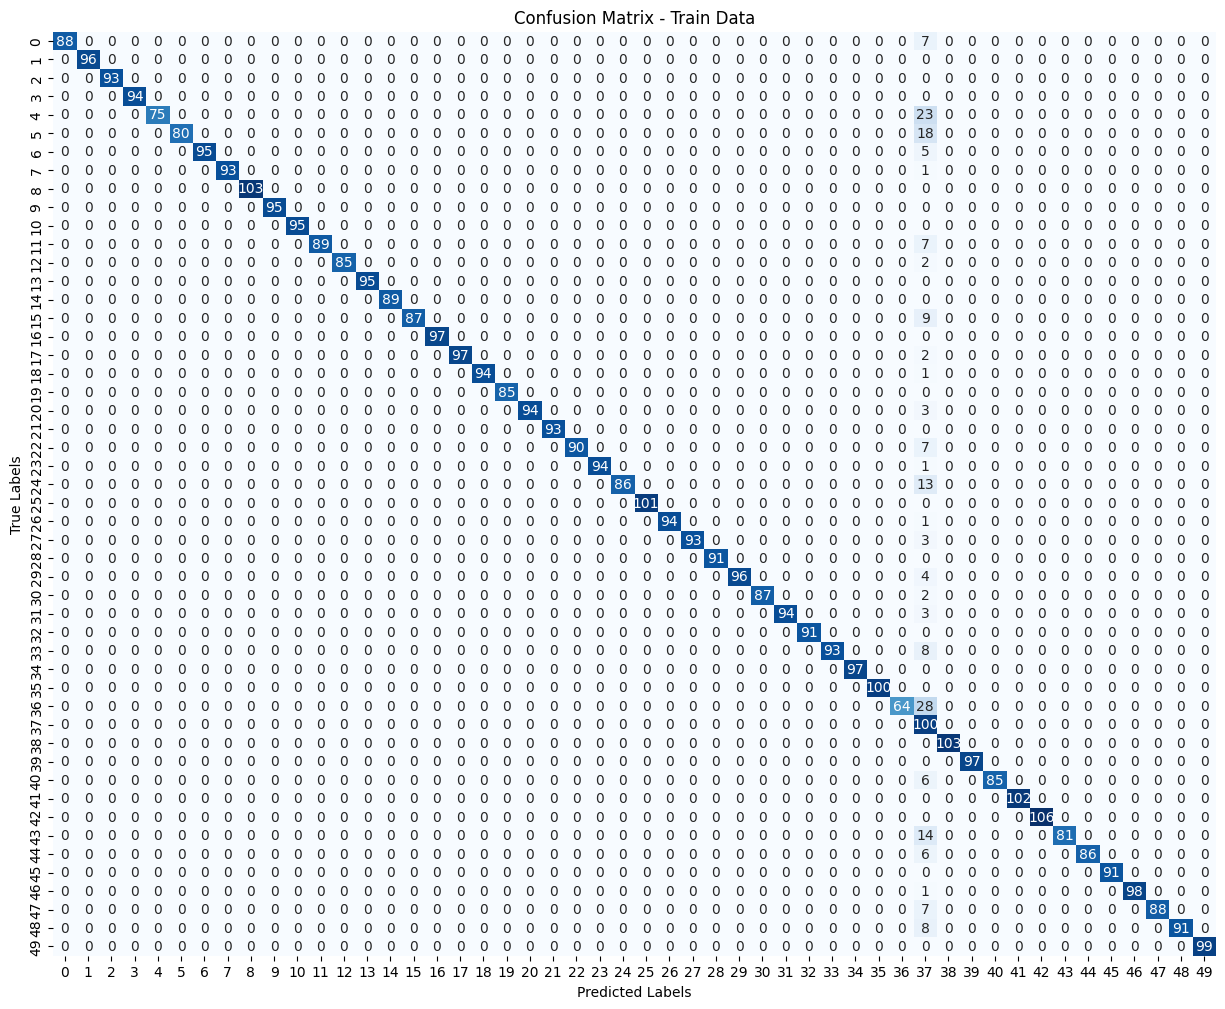

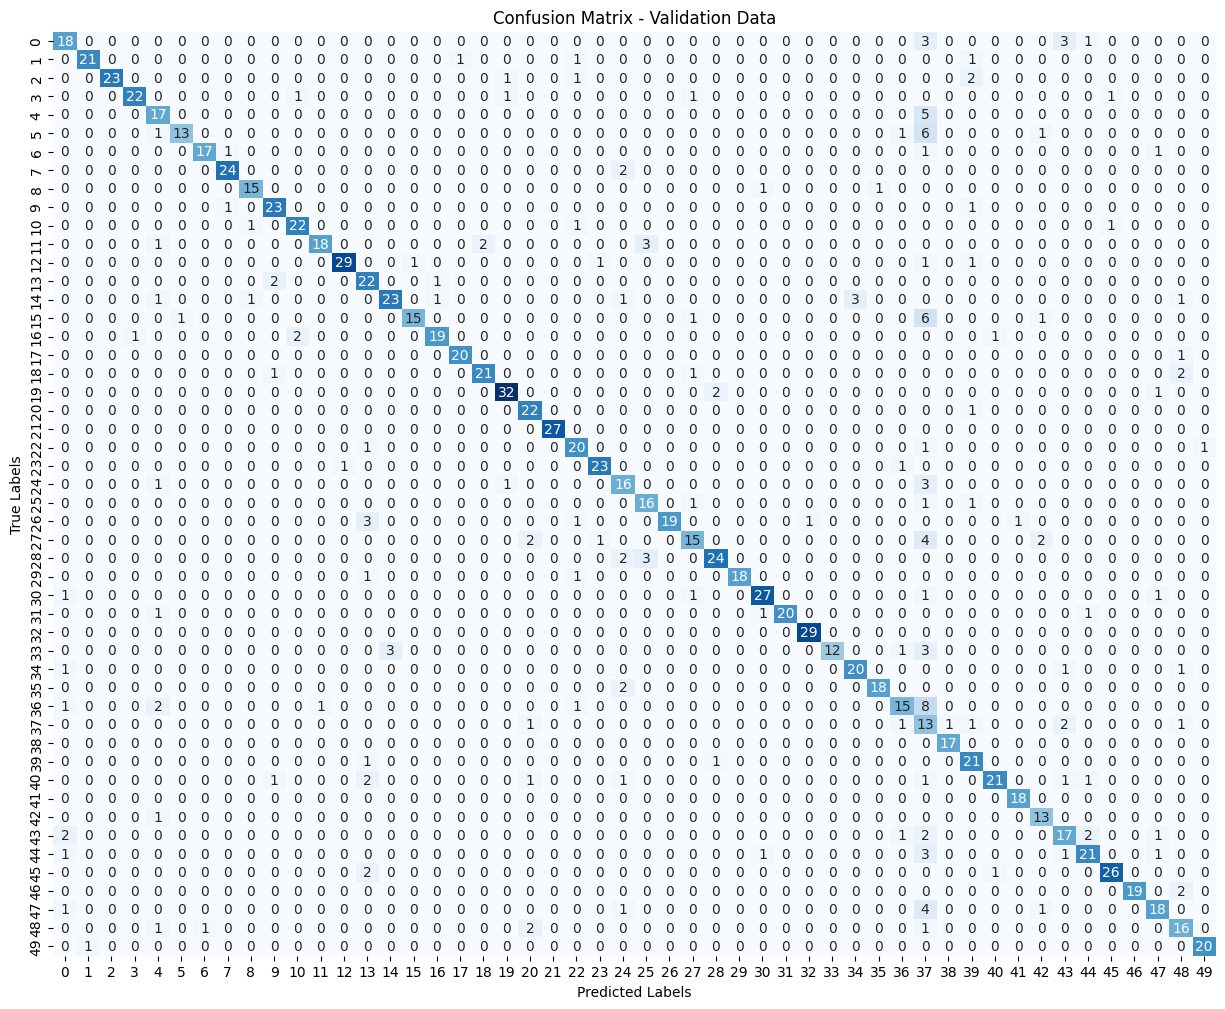

In [29]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get true labels for train and validation data
train_true_labels = y_train
val_true_labels = y_val

# Calculate confusion matrices
train_confusion_matrix = confusion_matrix(np.argmax(train_true_labels, axis=1), np.argmax(model.predict(x_train), axis=1))
val_confusion_matrix = confusion_matrix(np.argmax(val_true_labels, axis=1), np.argmax(model.predict(x_val), axis=1))

# Plot the confusion matrix for train dataset
plt.figure(figsize=(15, 12))
sns.heatmap(train_confusion_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Train Data')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show();

# Plot the confusion matrix for validation dataset
plt.figure(figsize=(15, 12))
sns.heatmap(val_confusion_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Validation Data')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show();

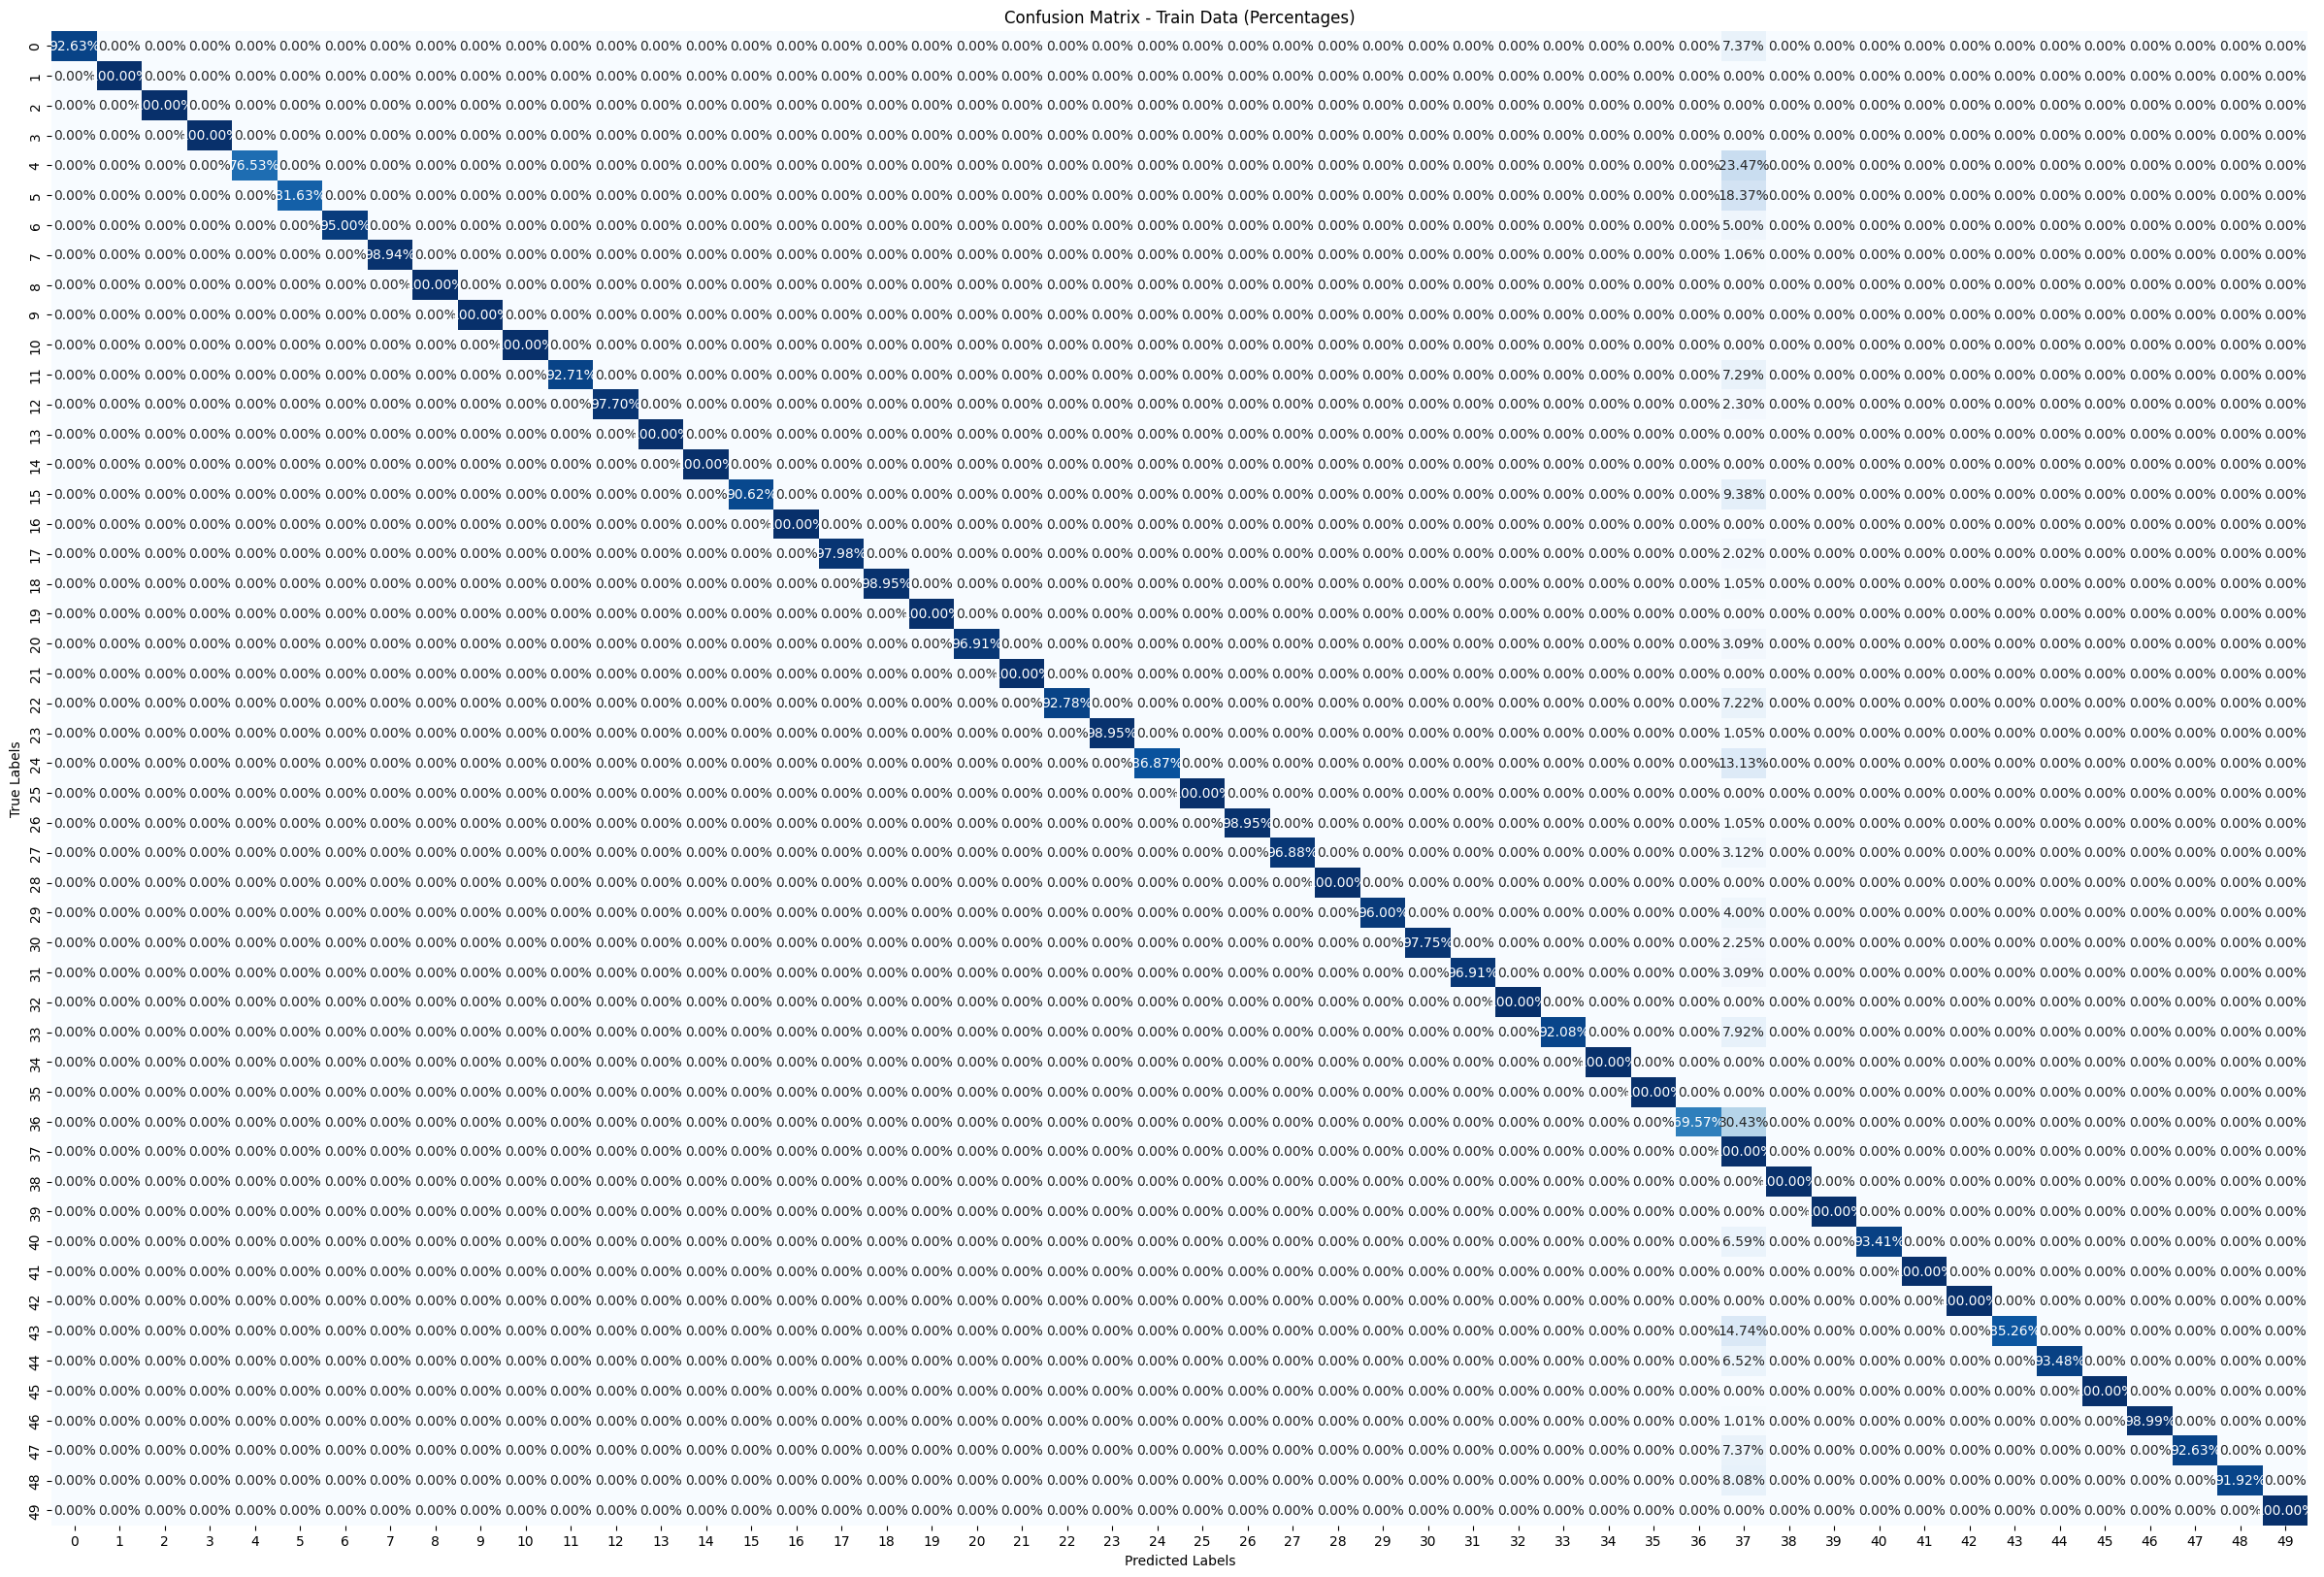

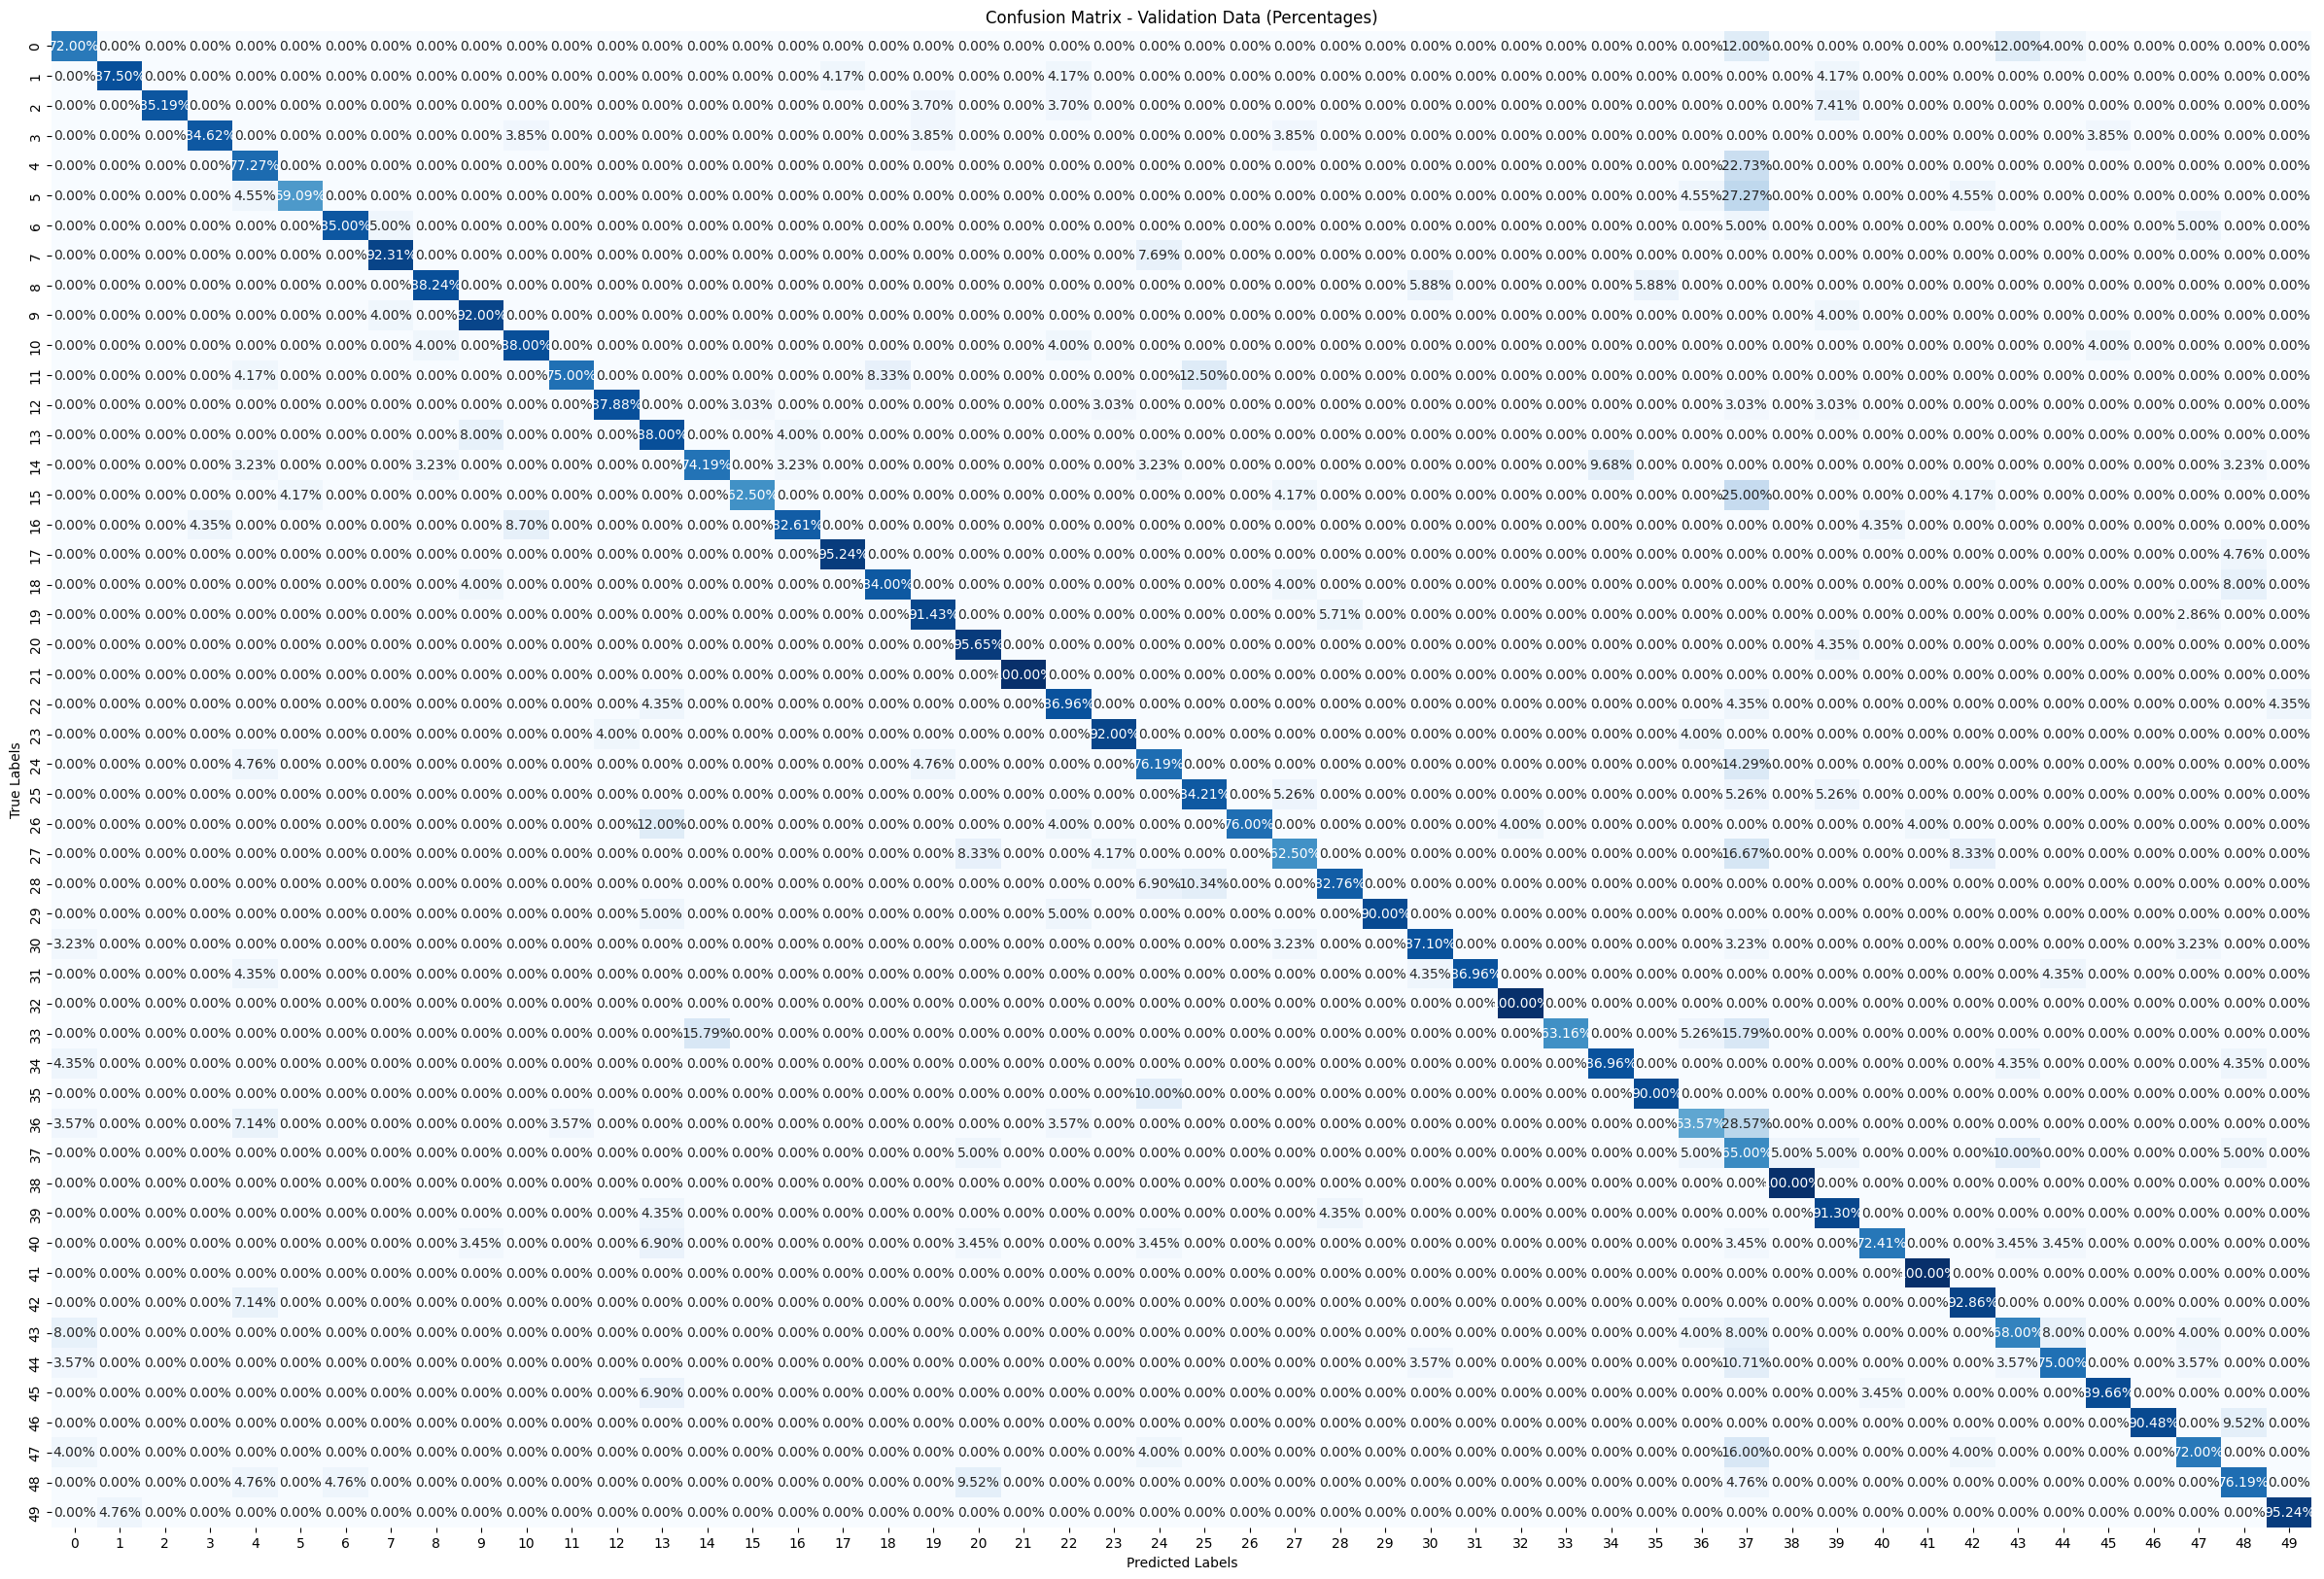

In [30]:
# Calculate confusion matrix percentages
train_confusion_matrix_percent = train_confusion_matrix.astype('float') / train_confusion_matrix.sum(axis=1)[:, np.newaxis]
val_confusion_matrix_percent = val_confusion_matrix.astype('float') / val_confusion_matrix.sum(axis=1)[:, np.newaxis]

# Plot the confusion matrix for train dataset with percentages
plt.figure(figsize=(30, 20))
sns.heatmap(train_confusion_matrix_percent, annot=True, fmt='.2%', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Train Data (Percentages)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show();

# Plot the confusion matrix for validation dataset with percentages
plt.figure(figsize=(30, 20))
sns.heatmap(val_confusion_matrix_percent, annot=True, fmt='.2%', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Validation Data (Percentages)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show();


In [31]:
from sklearn.metrics import accuracy_score

# Calculate validation accuracy
val_accuracy = accuracy_score(np.argmax(val_true_labels, axis=1), np.argmax(model.predict(x_val), axis=1))

# Print validation accuracy
print("Validation Accuracy:", val_accuracy)


38/38 [==============================] - 2s 47ms/step
Validation Accuracy: 0.8291666666666667
